# Muscle Synergies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.io import loadmat

In this notebook we will explore the concept of synergy in EMG recording. We will be working with high density sEMG dataset.

Let's start with the basic loading and preprocessing. Install gdown and download file if you haven't.

In [ ]:
# !pip install gdown

In [2]:
# import gdown
# url = "https://drive.google.com/uc?id=1Y8Zsm3e2KhElaQbcKykUURS65a3ce27g"
# output = "subj1_relevant_vars.mat"
# gdown.download(url, output, quiet = False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1Y8Zsm3e2KhElaQbcKykUURS65a3ce27g
From (redirected): https://drive.google.com/uc?id=1Y8Zsm3e2KhElaQbcKykUURS65a3ce27g&confirm=t&uuid=f9a249af-5837-46e3-8f86-cb3d055ef4ad
To: c:\Users\Neizo\Documents\GitHub\NSSP_421_Group_M\Project3\EX12\subj1_relevant_vars.mat
100%|██████████| 1.48G/1.48G [03:56<00:00, 6.24MB/s]


'subj1_relevant_vars.mat'

In [3]:
data = loadmat("subj1_relevant_vars.mat")
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Fs', 'adjusted_class_new', 'adjusted_repetition_new', 'emg_flexors_new'])

In [4]:
emg_data = data["emg_flexors_new"]
print(emg_data.shape)

emg_data = emg_data.reshape(emg_data.shape[0], 64) # reshape to 64 channels
fs = data["Fs"][0, 0] # sampling frequency


(3000000, 8, 8)


In [15]:
emg_data.shape

(3000000, 64)

In [5]:
from scipy.signal import butter
from scipy.signal import sosfiltfilt
import time


sos = butter(N=4, fs=fs, Wn=(5, 500), btype="bandpass", output="sos")
t = time.time()
emg_filtered = sosfiltfilt(sos, emg_data)
print("Elapsed time: ", time.time() - t)

Elapsed time:  75.39587664604187


In [6]:
from scipy.ndimage import convolve1d
# Easier method to compute the envelope 

emg_subsampled = emg_filtered[::2, :] # subsample by steps of 2 to reduce data size for easier computation
emg_rectified = emg_subsampled ** 2 # rectify the signal. We could also use abs

weights = np.ones(200)
t = time.time()
emg_envelope_200 = convolve1d(emg_rectified, weights=weights, axis=0)
print("Elapsed time: ", time.time() - t)

Elapsed time:  14.618494272232056


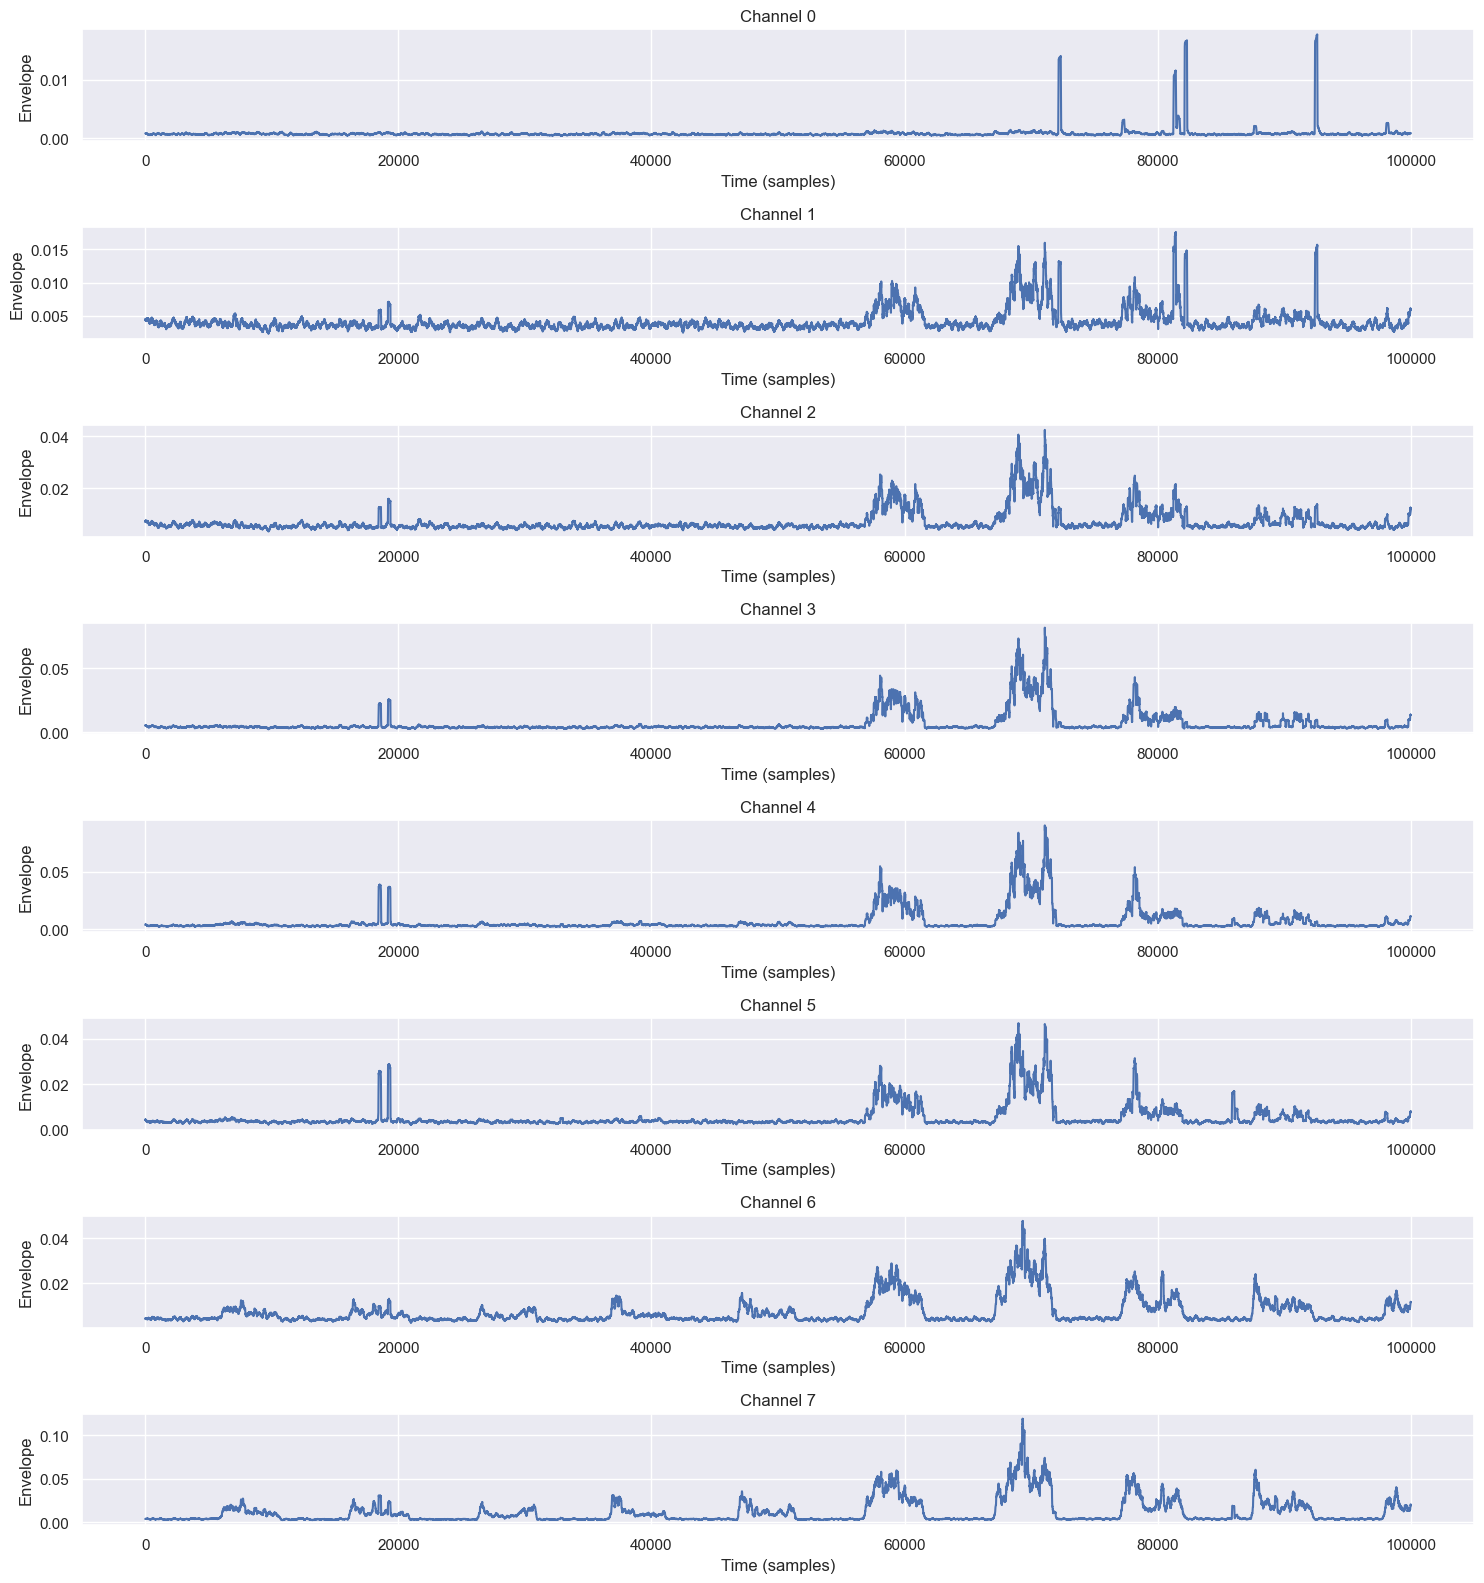

In [7]:
#lets take a quick look at the data

fig, ax = plt.subplots(8, 1, figsize=(15, 16))
for i in range(8):
    ax[i].plot(emg_envelope_200[:100000, i])
    ax[i].set_title("Channel {}".format(i))
    ax[i].set_xlabel("Time (samples)")
    ax[i].set_ylabel("Envelope")

plt.tight_layout()

# NMF for synergy

In [8]:
from sklearn.decomposition import NMF
from tqdm.notebook import tqdm

# For now let's just use 3 components. Parameters: init="nndsvda", max_iter=500.

nmf = NMF(n_components=3, init="nndsvda", max_iter=500)

t = time.time()
nmf.fit(emg_envelope_200)
print("Elapsed time: ", time.time() - t)

# Use nmf.fit_transform (W) and nmf.components_ (H) to decompose the EMG data into muscle synergies and activation coefficients.
W = nmf.fit_transform(emg_envelope_200)
H = nmf.components_

Elapsed time:  36.62527370452881


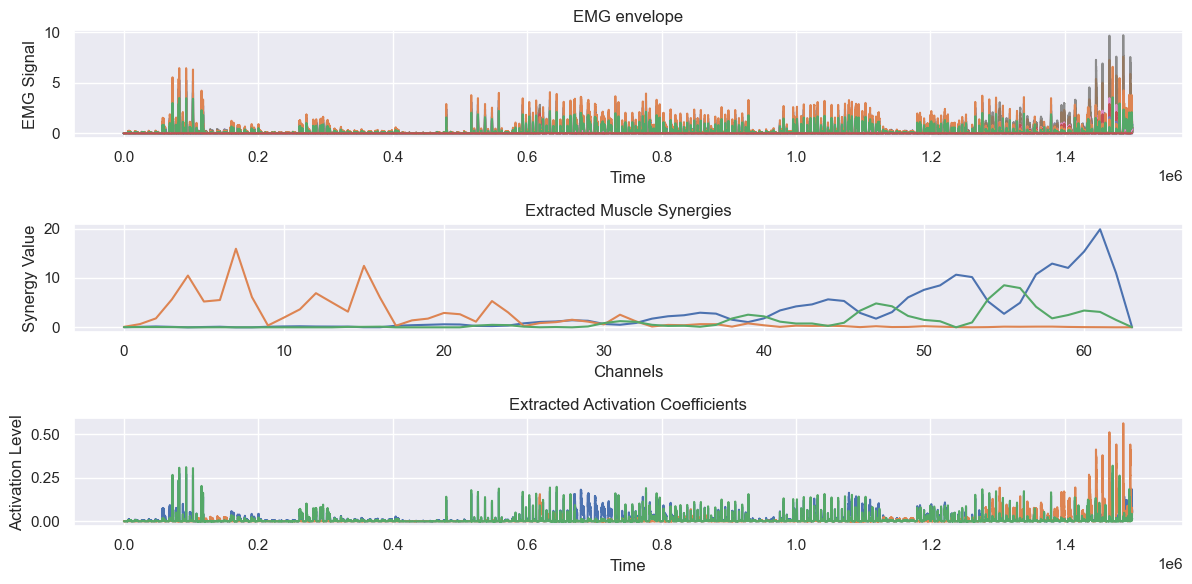

In [9]:
# Plot synthetic EMG data
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(emg_envelope_200)
plt.title('EMG envelope')
plt.xlabel('Time')
plt.ylabel('EMG Signal')

# Plot extracted synergies
plt.subplot(3, 1, 2)
plt.plot(H.T)
plt.title('Extracted Muscle Synergies')
plt.xlabel('Channels')
plt.ylabel('Synergy Value')

# Plot extracted activation coefficients
plt.subplot(3, 1, 3)
plt.plot(W)
plt.title('Extracted Activation Coefficients')
plt.xlabel('Time')
plt.ylabel('Activation Level')

plt.tight_layout()

The first plot shows the EMG envelop. This data is a mixture of muscle synergies over time across different EMG channels.

The second plot displays the synergies as extracted by the NMF. Each line represents one synergy and how it contributes to each EMG channel.

The third plot illustrates the activation coefficients over time. These coefficients indicate when and how strongly each synergy is activated throughout the dataset.

Observing the generated plots, we notice distinct patterns in the muscle synergies' distribution and activation. The orange synergy predominantly influences the initial half of the EMG channels, whereas the blue synergy appears more significantly in the latter half. In terms of activation timing, the orange synergy exhibits primary activation towards the end of the time period. In contrast, the blue synergy demonstrates a more pronounced activation around the midpoint. Notably, the green synergy, which was not previously mentioned, shows a consistent level of activation throughout the entire duration. This consistent activation suggests a more fundamental role of the green synergy in the overall muscle function.

### Reconstruction error
Moving forward, we will explore the difference in reconstruction error associated with varying the number of components in Non-negative Matrix Factorization (NMF). This analysis will help us understand the impact of different component counts on the accuracy and fidelity of the NMF model in representing the original EMG data.

In [10]:
reconstruction_err_200 = np.zeros(9)

# we will do NMF with 2 to 10 components
for i in range(9):
    print("Running NMF with {} components".format(i + 2))
          
    nmf = NMF(n_components=(i + 2), init="nndsvda", max_iter=500)

    t = time.time()
    nmf.fit(emg_envelope_200)
    print("Elapsed time: ", time.time() - t)

    reconstruction_err_200[i] = nmf.reconstruction_err_

Running NMF with 2 components
Elapsed time:  22.290085554122925
Running NMF with 3 components
Elapsed time:  36.087090730667114
Running NMF with 4 components
Elapsed time:  40.56393027305603
Running NMF with 5 components
Elapsed time:  63.09248661994934
Running NMF with 6 components
Elapsed time:  66.14411306381226
Running NMF with 7 components


c:\Users\Neizo\anaconda3\envs\computervision\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  204.62734031677246
Running NMF with 8 components
Elapsed time:  193.9880723953247
Running NMF with 9 components


c:\Users\Neizo\anaconda3\envs\computervision\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  286.93692278862
Running NMF with 10 components


c:\Users\Neizo\anaconda3\envs\computervision\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  301.0361406803131


We can also vary the parameters of the envelop to see how it can affect the NMF. This can illustrate how using different preprocessing pipeline can affect the synergy of NMF

In [11]:
weights = np.ones(100)
t = time.time()
emg_envelope_100 = convolve1d(emg_rectified, weights=weights, axis=0)
print("Elapsed time: ", time.time() - t)

Elapsed time:  10.40263557434082


In [13]:
reconstruction_err_100 = np.zeros(9)
for i in range(9):
    nmf = NMF(n_components=(i + 2), init="nndsvda", max_iter=500)

    t = time.time()
    nmf.fit(emg_envelope_100)
    print("Elapsed time: ", time.time() - t)

    reconstruction_err_100[i] = nmf.reconstruction_err_

Elapsed time:  18.00194263458252
Elapsed time:  55.606027126312256
Elapsed time:  77.57716941833496
Elapsed time:  131.38537430763245
Elapsed time:  153.22592782974243
Elapsed time:  211.3319592475891


c:\Users\Neizo\anaconda3\envs\computervision\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  284.51461935043335


c:\Users\Neizo\anaconda3\envs\computervision\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  288.8824653625488


c:\Users\Neizo\anaconda3\envs\computervision\lib\site-packages\sklearn\decomposition\_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


Elapsed time:  319.64773178100586


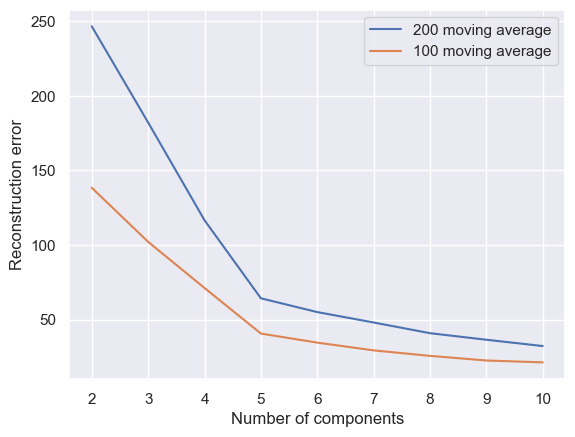

In [14]:
#lets plot the reconstruction error

fig, ax = plt.subplots()
ax.plot(np.arange(2, 11), reconstruction_err_200, label="200 moving average")
ax.plot(np.arange(2, 11), reconstruction_err_100, label="100 moving average")
ax.set_xlabel("Number of components")
ax.set_ylabel("Reconstruction error")
ax.legend()